In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


### Reshaping images
1. resized to 256x256 pixels
2. cropped to 224x224 pixels required by AlexNet
3. converted to tensor and normalized as suggested by PyTorch

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Download data

In [3]:
#Downloading training data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])
print(len(train_data)) 
print(len(val_data))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2)

#Downloading test data
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

#Class labels


classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Files already downloaded and verified
40000
10000
Files already downloaded and verified


In [4]:
data = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
print(len (data))
print(len (test_data))

Files already downloaded and verified
50000
10000


### Show random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


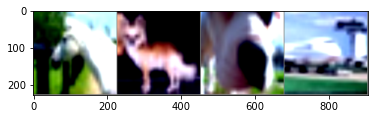

Horse   Dog   Dog Airplane


In [5]:
#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Initialize AlexNet
Here we initialize AlexNet and freeze the weights so that the pretrained weights are not modified

In [6]:
#Now using the AlexNet
from torchvision import models
AlexNet = models.alexnet(pretrained=True)

# Freeze model weights
for param in AlexNet.parameters():
    param.requires_grad = False

#Model description
AlexNet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### moddify the last layer (10 output classes)

In [12]:
# Add on classifier
AlexNet.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 10),                   
                      nn.LogSoftmax(dim=1))

AlexNet.to(torch.device("cuda:0"))
AlexNet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet.parameters(), lr=0.001, momentum=0.9)


In [14]:
epochs = 10
device = 'cuda:0'

# Training

In [15]:
epoch_data = []
train_epoch = []
val_epoch = []
for epoch in range(epochs):  # loop over the dataset multiple times
    print('\rProgress for training: [{}/{}]'.format(epoch+1, epochs), end='', flush=True)
    epoch_data.append(epoch + 1)
    running_loss = 0.0
    running_loss_val = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() / 4 #batchLoss / batch_size
    for i, data in enumerate(val_loader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward only
        output = AlexNet(inputs)
        loss = criterion(output, labels)

        # print statistics
        running_loss_val += loss.item() / 4 #batchLoss / batch_size
    train_epoch.append(running_loss / len(trainloader))
    val_epoch.append(running_loss_val / len(val_loader))
    

print('\nFinished Training of AlexNet')

Progress for training: [10/10]
Finished Training of AlexNet


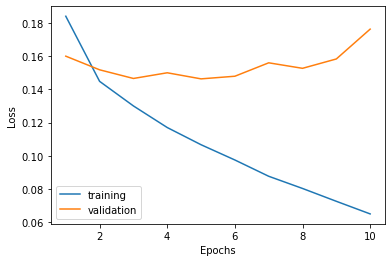

In [16]:
plt.plot(range(1,epochs+1), train_epoch,label='training')
plt.plot(range(1,epochs+1),val_epoch, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing

In [17]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\nAccuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 80 %


In [38]:
torch.save(AlexNet.state_dict(), "alex_FE") # Feature extraction